# On this Notebook
This is a replication of the original analysis performed in the paper by [Waade & Enevoldsen 2020](missing). This replication script will not be updated as it is intended for reproducibility. Any deviations from the paper is marked with bold for transparency.

---


# 2.2 Using tomsup
One of the advantages of computational models of cognitive processes is that the implications of the model can beworked out by simulating the model’s behavior in a variety of situations.  tomsup in particular, allows to test the k-ToM model as it plays a wide set of game-theoretical situations (e.g.  Matching Pennies or Prisoner’s Dilemma), ininteraction with a variety of different agents (e.g.  other k-ToM or less sophisticated agents), within different possiblesettings (e.g. repeated interactions with the same opponent, or round robin tournaments). In order to better understand the setup of the tomsup package, we start with the case of two simple agents interacting, followed by a simple exampleusing k-ToM agents, which will also illustrate how one might implement tomsup in an experiment.  Lastly, we will show how to run a simulation using multiple agents as well as how to plot the evolving internal states of a k-ToM agent.In this simple scenario two agents are playing the Matching Pennies game. One agent hides a penny in one hand: let’s say chooses 0 for hiding in the left hand, and 1 in the right.  The other agent has to guess where the penny is. If the second agent guesses (chooses the same hand as the first), it wins and the first loses. In other words, the first agent wants to choose the hand that the second will not choose and the second wants to choose the hand that the first chooses. In this example, one of the agents implements the Random Bias strategy (e.g. has a 60 percent probabilityof choosing right over left), while the other implements a classic Q-learning strategy (a model free reinforcement learning mechanism updating the expected reward of choosing a specific option on a trial by trial basis). The full list of strategies already implemented in tomsup is accessible using the function `valid_agents()`. The user first has to install the tomsup package developed using python 3.6 (Van Rossum & Drake, 2009).  Thepackage can be downloaded and installed using pip:

```pip3  install  tomsup```

**However, in this notebook we will assume the user simply downloaded the git. Feel free to skip the next code chunk if that is not the case.**

In [1]:
#assuming you are in the github folder change the path - not relevant if tomsup is installed via. pip
import os
print(os.getcwd())
os.chdir("..") # go out of the tutorials folder
print(os.getcwd())

/Users/au561649/Desktop/Github/tomsup/python package/tutorials
/Users/au561649/Desktop/Github/tomsup/python package


Both approaches will also install the required dependencies. Now tomsup can be imported into Python following the lines;

In [2]:
import tomsup as ts

We will also set a arbitrary seed for to ensure reproducibility;

In [3]:
import random

random.seed(1995)  # The date of birth of the first author

First we need to set up the Matching Pennies game. As different games are defined by different payoff matrices, we set up the game by creating the appropriate payoff matrix using the ```PayoffMatrix``` class. 

In [4]:
# initiate the competitive matching pennies game
penny = ts.PayoffMatrix(name='penny_competitive')

#print the payoff matrix
print(penny)

<Class PayoffMatrix, Name = penny_competitive> 
The payoff matrix of agent 0
       |  Choice agent 1
       |    |  0 |  1 |
       | ------------ |
Choice |  0 |  1 | -1 |
agent 0|  1 | -1 |  1 |
 
The payoff matrix of agent 1
       |  Choice agent 1
       |    |  0 |  1 |
       | ------------ |
Choice |  0 | -1 |  1 |
agent 0|  1 |  1 | -1 |
 



The Matching Pennies game is a zero sum game, meaning that for one agent to get a reward, the opponent has to lose. Agents have thus to predict their opponents' behavior, which is ideal for investigating \gls{tom}. Note that to explore other payoff matrices included in the package, or to learn how to specify a custom payoff matrix, the user can type the \texttt{help(ts.PayoffMatrix)} command.

Then we create the first of the two competing agents:


In [5]:
# define the random bias agent, which chooses 1 70 percent of the time, and call the agent "jung"
jung = ts.RB(bias=0.7)

# Examine Agent
print(f"jung is a class of type: {type(jung)}")
if isinstance(jung, ts.Agent):  
    print(f"but jung is also an instance of the parent class ts.Agent")

# let us have Jung make a choice 
choice = jung.compete()

print(f"jung chose {choice} and his probability for choosing 1 was {jung.get_bias()}.")

jung is a class of type: <class 'tomsup.agent.RB'>
but jung is also an instance of the parent class ts.Agent
jung chose 1 and his probability for choosing 1 was 0.7.



Note that it is possible to create one or more agents simultaneously using the convenient \texttt{create\_agents()} and passing any starting parameters to it in the form of a dictionary. 

In [6]:
# create a reinforcement learning agent
skinner = ts.create_agents(agents='QL', start_params={'save_history': True}) 



Now that both agents are created, we have them play against each other. 


** Note: you can remove the print() aorund the .head() to get a nicer printout of the dataframe **

In [7]:
# have the agents compete for 30 rounds
results = ts.compete(jung, skinner, p_matrix=penny, n_rounds=30)

# examine results
print(results.head()) #inspect the first 5 rows of the dataframe


   round  choice_agent0  choice_agent1  payoff_agent0  payoff_agent1
0      0              0              0              1             -1
1      1              0              0              1             -1
2      2              0              1             -1              1
3      3              0              1             -1              1
4      4              1              0             -1              1



The data frame stores the choice of each agent as well as their resulting payoff. Simply summing the payoff columns would determine the winner.


## k-ToM
Here we will present some simple examples of the k-ToM agent. For a more in-depth description we recommend checking the expanded introduction on the Github repository\footnote{\label{tom_tut}\url{https://github.com/KennethEnevoldsen/tomsup/blob/master/tutorials/introduction_to_tom.ipynb}}.

We will start of by creating a 0-ToM with default priors and \texttt{save\_history=True} to examine the workings of it. Notice that setting \texttt{save\_history} is turned off by default to save on memory which is especially problematic for ToM agents with high sophistication level.

In [8]:
# Creating a simple 1-ToM with default parameters
tom_1 = ts.TOM(level=1, dilution=None, save_history=True)

# Extract the parameters
print(tom_1.get_parameters())


{'volatility': -2, 'b_temp': -1, 'bias': 0}



Note that k-ToM agents as default uses agnostic starting beliefs. These can be shown in detail and specified as desired, as shown in \autoref{sec:appendix_priors}.

To increase the agent's tendency to choose one we could simply increase its bias. Similarly, if we want the agent to behave in a more more deterministic fashion we can decrease the behavioural temperature. When the parameter values are set, we can play the agent against an opponent using the \texttt{.compete()} method. Where \texttt{agent} denote the agent in the payoff matrix (0 or 1) and the \text{op\_choice} denote the choice of the opponent during the previous round. 

In [9]:
tom_2 = ts.TOM(level = 2, volatility= -2,  b_temp= -2, # more deterministic
               bias = 0, dilution = None, save_history = True)
choice = tom_2.compete(p_matrix=penny, agent=0, op_choice=None)
print("tom_2 choose:", choice)


tom_2 choose: 1


The user is recommended to have the 1-ToM and the 2-ToM agents compete using the previously presented \texttt{ts.compete()} function for simplicity. However, to make the process more transparent for the user in the following we create a simple for-loop:


In [10]:
tom_2.reset() # reset before start


prev_choice_1tom = None
prev_choice_2tom = None
for trial in range(1, 4):
    # note that op_choice is choice on previous turn
    # and that agent is the agent you respond to in the payoff matrix
    choice_1 = tom_1.compete(p_matrix=penny, agent=0, 
                            op_choice=prev_choice_1tom)
    choice_2 = tom_2.compete(p_matrix=penny, agent=1,
                            op_choice=prev_choice_2tom)

    # update previous choice
    prev_choice_1tom = choice_1
    prev_choice_2tom = choice_2

    print(f"Round {trial}", f"  1-ToM choose {choice_1}", f"  2-ToM choose {choice_2}", sep="\n")

Round 1
  1-ToM choose 1
  2-ToM choose 0
Round 2
  1-ToM choose 0
  2-ToM choose 1
Round 3
  1-ToM choose 1
  2-ToM choose 1


A for loop like this can be used to implement k-ToM in an experimental setting by replacing the agent with the behavior of a participant. Examples of such implementations (interfacing with PsychoPy \citep{Peirce2019PsychoPy2:Easy} are available in the documentation of the package: \url{https://github.com/KennethEnevoldsen/tomsup/tree/master/tutorials/psychopy_experiment}. 


In [11]:
tom_2.print_internal(keys_to_print=["p_k", "p_op"],  # print these two states
                     print_level=[0, 1])             # for the agent simulated opponents 0-ToM and 1-ToM


opponent_states
|   0-ToM
|   |   opponent_states
|   |   own_states
|   1-ToM
|   |   opponent_states
|   |   |   0-ToM
|   |   |   |   opponent_states
|   |   |   |   own_states
|   |   own_states
|   |   |   p_k:         [1.0]
own_states
|   p_k:         [0.40311816067370676, 0.5968818393262932]
|   p_op:        0.4692728878145314



For instance, we can note that the estimate of the opponent's sophistication level (\texttt{p\_k}) slightly favors a 1-ToM as opposed to a 0-ToM and that the average probability of the opponent choosing one (\texttt{p\_op}) slightly favors 1 (which was indeed the option the opponent chose). These estimates are quite uncertain due to the few rounds played. More information on how to interpret the internal states of the ToM agent is available in the documentation of the package, e.g. by using the help function \texttt{help(tom\_2.print\_internal)}.

## Multiple Agents and Visualizing Results
The above syntax is useful for small setups. However, the user might want to build larger simulations involving several agents to simulate data for experimental setup or test underlying assumptions. The package provides syntax for quickly iterating over multiple agents, rounds and even simulations. We will here show a quick example along with how to visualize the results and internal states of ToM agents.

In [12]:
# Create a list of agents
agents = ['RB', 'QL', 'WSLS', '1-TOM', '2-TOM']
# And set their starting parameters. An empty dictionary denotes default values
start_params = [{'bias': 0.7}, {'learning_rate': 0.5}, {}, {}, {}] 

group = ts.create_agents(agents, start_params) # create a group of agents

# Specify the environment
# round_robin e.g. each agent will play against all other agents
group.set_env(env='round_robin') 

# Finally, we make the group compete 20 simulations of 30 rounds
results = group.compete(p_matrix=penny, n_rounds=30,
                        n_sim=20, save_history=True)

Currently the pair, ('RB', 'QL'), is competing for 20                         simulations, each containg 30 rounds.
	Running simulation 1 out of 20
	Running simulation 2 out of 20
	Running simulation 3 out of 20
	Running simulation 4 out of 20
	Running simulation 5 out of 20
	Running simulation 6 out of 20
	Running simulation 7 out of 20
	Running simulation 8 out of 20
	Running simulation 9 out of 20
	Running simulation 10 out of 20
	Running simulation 11 out of 20
	Running simulation 12 out of 20
	Running simulation 13 out of 20
	Running simulation 14 out of 20
	Running simulation 15 out of 20
	Running simulation 16 out of 20
	Running simulation 17 out of 20
	Running simulation 18 out of 20
	Running simulation 19 out of 20
	Running simulation 20 out of 20
Currently the pair, ('RB', 'WSLS'), is competing for 20                         simulations, each containg 30 rounds.
	Running simulation 1 out of 20
	Running simulation 2 out of 20
	Running simulation 3 out of 20
	Running simulation

Following the simulation, a data frame can be extracted as before, with additional columns reporting simulation number, competing agent pair (\texttt{agent0} and \texttt{agent1}) and if \texttt{save\_history=True} it will also add two columns denoting the internal states of each agent, e.g. estimates and expectations at each trial.


In [13]:
res = group.get_results()
print(res.head(1)) # print the first row


   n_sim  round  choice_agent0  choice_agent1  payoff_agent0  payoff_agent1  \
0      0      0              1              0             -1              1   

  history_agent0                                     history_agent1 agent0  \
0  {'choice': 1}  {'choice': 0, 'expected_value0': 0.5, 'expecte...     RB   

  agent1  
0     QL  


In [14]:
res

,n_sim,round,choice_agent0,choice_agent1,payoff_agent0,payoff_agent1,history_agent0,history_agent1,agent0,agent1
0,0,0,1,0,-1,1,{'choice': 1},"{'choice': 0, 'expected_value0': 0.5, 'expecte...",RB,QL
1,0,1,1,0,-1,1,{'choice': 1},"{'choice': 0.0, 'expected_value0': 0.5, 'expec...",RB,QL
2,0,2,1,0,-1,1,{'choice': 1},"{'choice': 0.0, 'expected_value0': 0.5, 'expec...",RB,QL
3,0,3,0,0,1,-1,{'choice': 0},"{'choice': 0.0, 'expected_value0': 0.5, 'expec...",RB,QL
4,0,4,0,0,1,-1,{'choice': 0},"{'choice': 0.0, 'expected_value0': 0.5, 'expec...",RB,QL
...,...,...,...,...,...,...,...,...,...,...
595,19,25,1,0,-1,1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 0, 'internal_states': {'opponent_st...",1-TOM,2-TOM
596,19,26,1,1,1,-1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",1-TOM,2-TOM
597,19,27,0,1,-1,1,"{'choice': 0, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",1-TOM,2-TOM
598,19,28,1,1,1,-1,"{'choice': 1, 'internal_states': {'opponent_st...","{'choice': 1, 'internal_states': {'opponent_st...",1-TOM,2-TOM


The package also provides convenient functions for plotting the agent's choices and performance. The following code plots results in \autoref{fig:heat} and \ref{fig:score_choice}.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

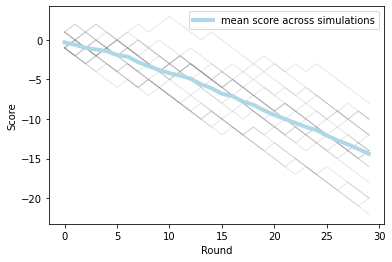

In [15]:
# plot a heatmap of the rewards for all agent in the tournament
group.plot_heatmap()

# plot the choices of the RB agent when competing against the Q-learning agent
group.plot_choice(agent0="RB", agent1="QL", agent=0, plot_individual_sim=False)

# plot the score of the RB agent when competing against the Q-learning agent
group.plot_score(agent0="RB", agent1="QL", agent=0)


Besides these general plots the package also contains a series of shortcuts for plotting $k$-ToM's internal states such as its estimate of its opponent's sophistication level (\autoref{fig:p_k}), in which it is seen that the 2-ToM correctly estimates the opponents estimates as having a sophistication level of 1 on average.\footnote{Note that 2-ToM is slightly biased away from concluding an opponent to be at level 0. This is probably because the higher-level 1-ToM model have more parameters and is more flexible, and therefore is easier to fit to the data. Future versions of the algorithm could include penalties for increased amounts of parameters.}


<Figure size 432x288 with 0 Axes>

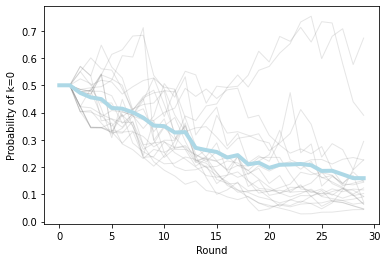

<Figure size 432x288 with 0 Axes>

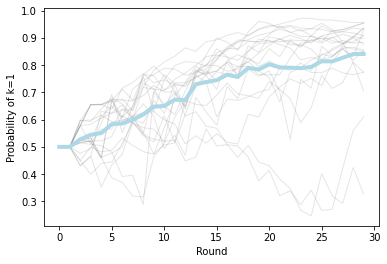

In [17]:
# plot 2-ToM estimate of its opponent sophistication level
group.plot_p_k(agent0="1-TOM", agent1="2-TOM", agent=1, level=0)
group.plot_p_k(agent0="1-TOM", agent1="2-TOM", agent=1, level=1)
